In [89]:
%%capture
!pip install -r ../requirements.txt

# Imports

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from datetime import datetime, timedelta
import yfinance as yf
import requests
import io
import feedparser
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
import time

In [65]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cpras\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cpras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cpras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [66]:
start_date = datetime(1971, 4, 2).date()

# FRED API Setup
Visit https://fredaccount.stlouisfed.org/apikeyl, request key, and save it as `fred_token.txt`

In [67]:
# Load API from txt file and create Fred object
with open('../fred_token.txt', 'r') as file:
    api_key = file.read().strip()

fred = Fred(api_key=api_key)

# Fetch FRED Economic Data

In [68]:
def fetch_fred_data(series_id, start_date="1971-04-02"):
    try:
        data = fred.get_series(series_id, observation_start=start_date)
    except Exception as e:
        print(f"Error fetching data for {series_id}: {e}")
        return None
    df = pd.DataFrame(data, columns=[series_id])
    df.index.name = "Date"
    return df

In [69]:
series_ids = {
    "MORTGAGE30US": "30-Year Fixed Mortgage Rate",
    "DGS10": "10-Year Treasury Yield",
    "FEDFUNDS": "Federal Funds Rate",
    "CPIAUCSL": "Consumer Price Index (CPI)",
    "UNRATE": "Unemployment Rate",
    "GDP": "Gross Domestic Product (GDP)",
    "FIXHAI": "Housing Affordability Index",
    "HOUST": "New Residential Construction",
    "PERMIT": "Building Permits",
    'DFF': "Discount Rate",
    'M2SL': "Money Supply M2",
    'M1SL': "Money Supply M1",
    'M1V': "Money Velocity M1",
    'M2V': "Money Velocity M2",
    'M3SL': "Money Supply M3",
    'M2REAL': "Real M2 Money Stock",
    'M1REAL': "Real M1 Money Stock",
    'M2REAL': "Real M2 Money Stock",
    'M1REAL': "Real M1 Money Stock",
    'PAYEMS': "All Employees: Total Nonfarm Payrolls",
    'CIVPART': "Civilian Labor Force Participation Rate",
    'JTSJOL': "Job Openings: Total Nonfarm",
    "PCEPI": "Personal Consumption Expenditures Price Index",
    "CPILFESL": "CPI for All Urban Consumers: Food",
    "PPIACO": "Producer Price Index for All Commodities",
    "SPCS20RSA": "S&P/Case-Shiller 20-City Composite Home Price Index",
    "MSPUS": "Median Sales Price of Houses Sold for the United States",
    "GDPC1": "Real Gross Domestic Product",
    "GNPCA": "Real Gross National Product",
    "A939RC0Q052SBEA": "Federal Government Current Expenditures",
    "EXPGS": "Exports of Goods and Services",
    "IR14240": "Effective Federal Funds Rate",
    "BOPGSTB": "Balance of Payments: Goods and Services",
    "TOTRESNS": "Total Reserves of Depository Institutions",
    "BUSLOANS": "Commercial and Industrial Loans",
    "RETAILSMSA": "Retail and Food Services Sales",
    "UMCSENT": "University of Michigan Consumer Sentiment",
    "PCEPI": "Personal Consumption Expenditures Price Index",
    "USEPUINDXD": "Economic Policy Uncertainty Index for the United States",
}
data_frames = {name: fetch_fred_data(code) for code, name in series_ids.items()}

# Stock & Bond Market Indicators (via Yahoo Finance)

In [70]:
yahoo_tickers = ['^GSPC', '^VIX', 'TLT', 'MBS', 'FNMA']  # S&P 500, VIX, 20+ Yr Treasury ETF, Mortgage-Backed Securities

yahoo_data = yf.download(yahoo_tickers, start="1971-04-02", group_by='ticker')

[*********************100%***********************]  5 of 5 completed


In [71]:
yahoo_data.columns

MultiIndex([(  'MBS',   'Open'),
            (  'MBS',   'High'),
            (  'MBS',    'Low'),
            (  'MBS',  'Close'),
            (  'MBS', 'Volume'),
            ( '^VIX',   'Open'),
            ( '^VIX',   'High'),
            ( '^VIX',    'Low'),
            ( '^VIX',  'Close'),
            ( '^VIX', 'Volume'),
            (  'TLT',   'Open'),
            (  'TLT',   'High'),
            (  'TLT',    'Low'),
            (  'TLT',  'Close'),
            (  'TLT', 'Volume'),
            ( 'FNMA',   'Open'),
            ( 'FNMA',   'High'),
            ( 'FNMA',    'Low'),
            ( 'FNMA',  'Close'),
            ( 'FNMA', 'Volume'),
            ('^GSPC',   'Open'),
            ('^GSPC',   'High'),
            ('^GSPC',    'Low'),
            ('^GSPC',  'Close'),
            ('^GSPC', 'Volume')],
           names=['Ticker', 'Price'])

In [72]:
# Flatten MultiIndex if needed
if isinstance(yahoo_data.columns, pd.MultiIndex):
    flat_data = yahoo_data.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index()
    flat_data = flat_data.pivot(index='Date', columns='Ticker')
    flat_data.columns = ['{}_{}'.format(ticker, col) for col, ticker in flat_data.columns]
    flat_data.index = pd.to_datetime(flat_data.index)
else:
    flat_data = yahoo_data.copy()

# Only keep Close prices
flat_data = flat_data.filter(like='Close')
# Rename columns for clarity
flat_data.columns = [col.replace('Close_', '') for col in flat_data.columns]

# Add to data_frames for merging
data_frames.update(flat_data.to_dict(orient='series'))

# Zillow Data

In [73]:
zillow_url = "https://files.zillowstatic.com/research/public_csvs/zhvi/Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1744322036"
zillow_data = pd.read_csv(zillow_url)

In [74]:
print(zillow_data.columns)

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31',
       ...
       '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
       '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31', '2025-02-28'],
      dtype='object', length=307)


In [75]:
# Filter for Seattle, WA and transpose the data to have dates as the index
zillow_data = zillow_data[zillow_data['RegionName'] == 'Seattle, WA']
zillow_data = zillow_data.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName']).set_index('RegionName').T
zillow_data.index = pd.to_datetime(zillow_data.index)
zillow_data = zillow_data.rename(columns={'Seattle, WA': 'Zillow_HPI'})

# News Sentiment
https://tradewithpython.com/news-sentiment-analysis-using-python

In [76]:
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 30

In [77]:
# U.S. and finance-specific sources
finance_domains = [
    "reuters.com", "bloomberg.com", "cnbc.com", "yahoo.com",
    "foxbusiness.com", "marketwatch.com", "wsj.com",
    "forbes.com", "businessinsider.com"
]

In [78]:
def chunk_date_range(start_date, end_date, delta_days=30):
    """Yield start and end date pairs split by delta_days chunks"""
    current = start_date
    while current < end_date:
        chunk_end = min(current + timedelta(days=delta_days), end_date)
        yield current, chunk_end
        current = chunk_end + timedelta(days=1)

def get_nltk_news_sentiment(topic="mortgage rates", start_date=datetime(2024, 1, 1)):
    today = datetime.today().date()
    all_results = []

    for domain in finance_domains:
        for chunk_start, chunk_end in chunk_date_range(start_date, today):
            start_str = chunk_start.strftime('%m/%d/%Y')
            end_str = chunk_end.strftime('%m/%d/%Y')
            search_query = f"{topic} site:{domain}"

            print(f"\n🔍 Searching {search_query} from {start_str} to {end_str}")

            googlenews = GoogleNews(lang='en', start=start_str, end=end_str)
            googlenews.search(search_query)

            for i in range(1, 6):  # Get first 5 pages per query
                try:
                    googlenews.getpage(i)
                    page_results = googlenews.results()
                    if not page_results:
                        break
                    all_results.extend(page_results)
                except Exception as e:
                    print(f"Error fetching page {i} for {domain}: {e}")
                    break
                time.sleep(1)

    if not all_results:
        print("❌ No results from any financial sources.")
        return pd.DataFrame()

    df = pd.DataFrame(all_results).drop_duplicates(subset="link")
    print(f"\n✅ Collected {len(df)} unique articles")

    records = []
    for i, row in df.iterrows():
        url = row.get('link')
        if pd.isna(url):
            continue
        if "&ved=" in url:
            url = url.split("&ved=")[0]

        try:
            article = Article(url, config=config)
            article.download()
            time.sleep(1)
            article.parse()

            text = article.text
            summary = text[:500] if text else ""
            title = article.title

            if not text and not title:
                continue

            article_date = row.get('datetime') or datetime.now()

            records.append({
                'Date': article_date,
                'Media': row.get('media', 'Unknown'),
                'Title': title,
                'Summary': summary
            })
            print(f"✅ Parsed: {title[:60]}")
        except Exception as e:
            print(f"⚠️ Skipping article due to error: {e}")
            continue

    if not records:
        print("❌ No articles successfully processed")
        return pd.DataFrame()

    news_df = pd.DataFrame(records)

    # Ensure Date column is datetime
    news_df['Date'] = pd.to_datetime(news_df['Date'], errors='coerce')
    news_df = news_df.dropna(subset=['Date'])
    news_df['Week'] = news_df['Date'].dt.to_period('W').dt.start_time

    # Sentiment Analysis
    sia = SentimentIntensityAnalyzer()
    news_df['Summary'] = news_df['Summary'].fillna('')
    news_df['Sentiment'] = news_df['Summary'].apply(lambda x: sia.polarity_scores(x))
    news_df['Compound'] = news_df['Sentiment'].apply(lambda x: x['compound'])
    news_df['Pos'] = news_df['Sentiment'].apply(lambda x: x['pos'])
    news_df['Neg'] = news_df['Sentiment'].apply(lambda x: x['neg'])
    news_df['Neu'] = news_df['Sentiment'].apply(lambda x: x['neu'])

    print(f"\n📈 Performing weekly aggregation...")
    try:
        weekly = news_df.groupby("Week").agg(
            NewsSentiment=("Compound", "mean"),
            NewsPos=("Pos", "mean"),
            NewsNeg=("Neg", "mean"),
            NewsNeu=("Neu", "mean"),
            NewsCount=("Compound", "count")
        )
        print(f"✅ Aggregated {len(weekly)} weeks of sentiment data")
        return weekly
    except Exception as e:
        print(f"⚠️ Aggregation failed: {e}")
        return news_df


In [79]:
# sentiment_df = get_nltk_news_sentiment("mortgage rates", start_date=start_date)

# Merge All

In [80]:
combined = pd.concat([df for df in data_frames.values()], axis=1)
combined = pd.concat([combined, zillow_data], axis=1)
combined = combined.resample("W").mean()

In [81]:
# Add Sentiment Features (per week)
# combined = combined.merge(sentiment_df, how="left", left_index=True, right_index=True)

In [82]:
combined.columns

Index(['MORTGAGE30US', 'DGS10', 'FEDFUNDS', 'CPIAUCSL', 'UNRATE', 'GDP',
       'FIXHAI', 'HOUST', 'PERMIT', 'DFF', 'M2SL', 'M1SL', 'M1V', 'M2V',
       'M3SL', 'M2REAL', 'M1REAL', 'PAYEMS', 'CIVPART', 'JTSJOL', 'PCEPI',
       'CPILFESL', 'PPIACO', 'SPCS20RSA', 'MSPUS', 'GDPC1', 'GNPCA',
       'A939RC0Q052SBEA', 'EXPGS', 'IR14240', 'BOPGSTB', 'TOTRESNS',
       'BUSLOANS', 'RETAILSMSA', 'UMCSENT', 'USEPUINDXD', 'MBS', '^VIX', 'TLT',
       'FNMA', '^GSPC', 'Zillow_HPI'],
      dtype='object')

# Forward and Back Fill
May want to comment out if planning to use tree-based models since they can handle missing data

In [83]:
# Fill missing values with forward fill method
combined.ffill(inplace=True)

# # Fill any remaining NaNs with backward fill method
# combined.bfill(inplace=True)

# Add Month as Feature
Seasonality information

In [84]:
combined['Month'] = combined.index.month

# EDA Visuals

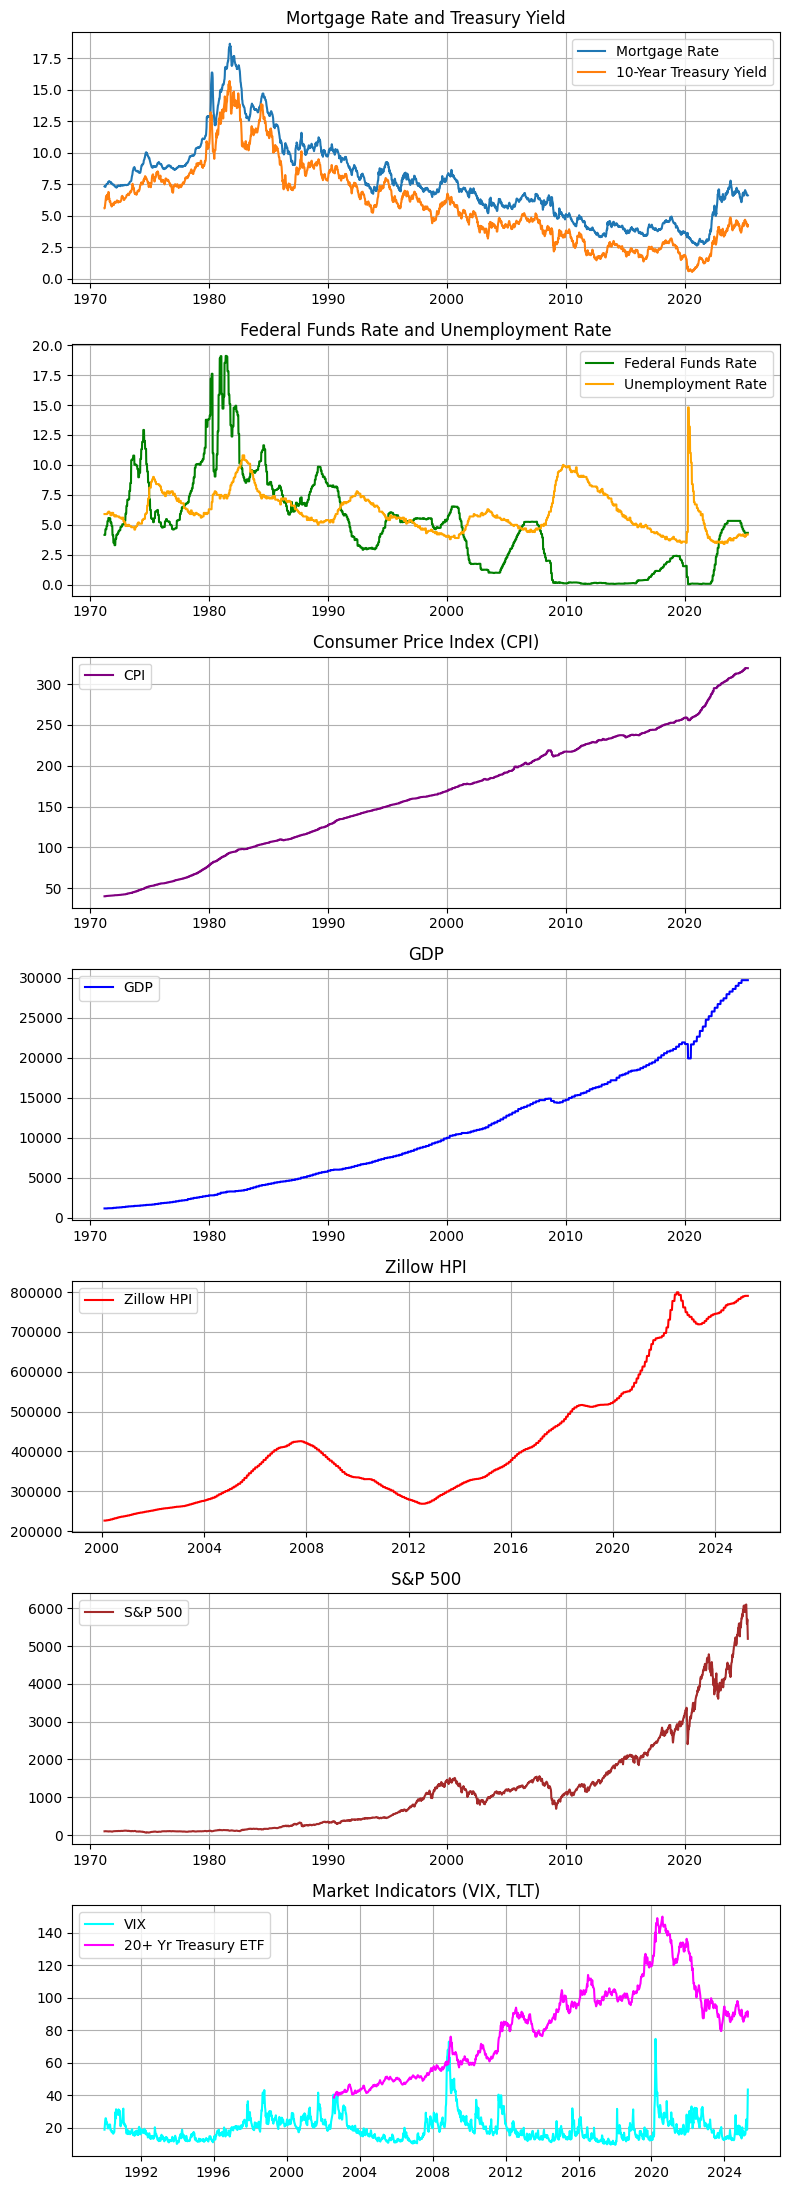

In [85]:
# Create a grid layout for subplots
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 22))

# Plot variables with similar scales together
axes[0].set_title("Mortgage Rate and Treasury Yield")
axes[0].plot(combined.index, combined["MORTGAGE30US"], label="Mortgage Rate")
axes[0].plot(combined.index, combined["DGS10"], label="10-Year Treasury Yield")
axes[0].legend()
axes[0].grid()

axes[1].set_title("Federal Funds Rate and Unemployment Rate")
axes[1].plot(combined.index, combined["FEDFUNDS"], label="Federal Funds Rate", color="green")
axes[1].plot(combined.index, combined["UNRATE"], label="Unemployment Rate", color="orange")
axes[1].legend()
axes[1].grid()

axes[2].set_title("Consumer Price Index (CPI)")
axes[2].plot(combined.index, combined["CPIAUCSL"], label="CPI", color="purple")
axes[2].legend()
axes[2].grid()

axes[3].set_title("GDP")
axes[3].plot(combined.index, combined["GDP"], label="GDP", color="blue")
axes[3].legend()
axes[3].grid()

axes[4].set_title("Zillow HPI")
axes[4].plot(combined.index, combined["Zillow_HPI"], label="Zillow HPI", color="red")
axes[4].legend()
axes[4].grid()

axes[5].set_title("S&P 500")
axes[5].plot(combined.index, combined["^GSPC"], label="S&P 500", color="brown")
axes[5].legend()
axes[5].grid()

axes[6].set_title("Market Indicators (VIX, TLT)")
axes[6].plot(combined.index, combined["^VIX"], label="VIX", color="cyan")
axes[6].plot(combined.index, combined["TLT"], label="20+ Yr Treasury ETF", color="magenta")
axes[6].legend()
axes[6].grid()

plt.tight_layout()
plt.show()

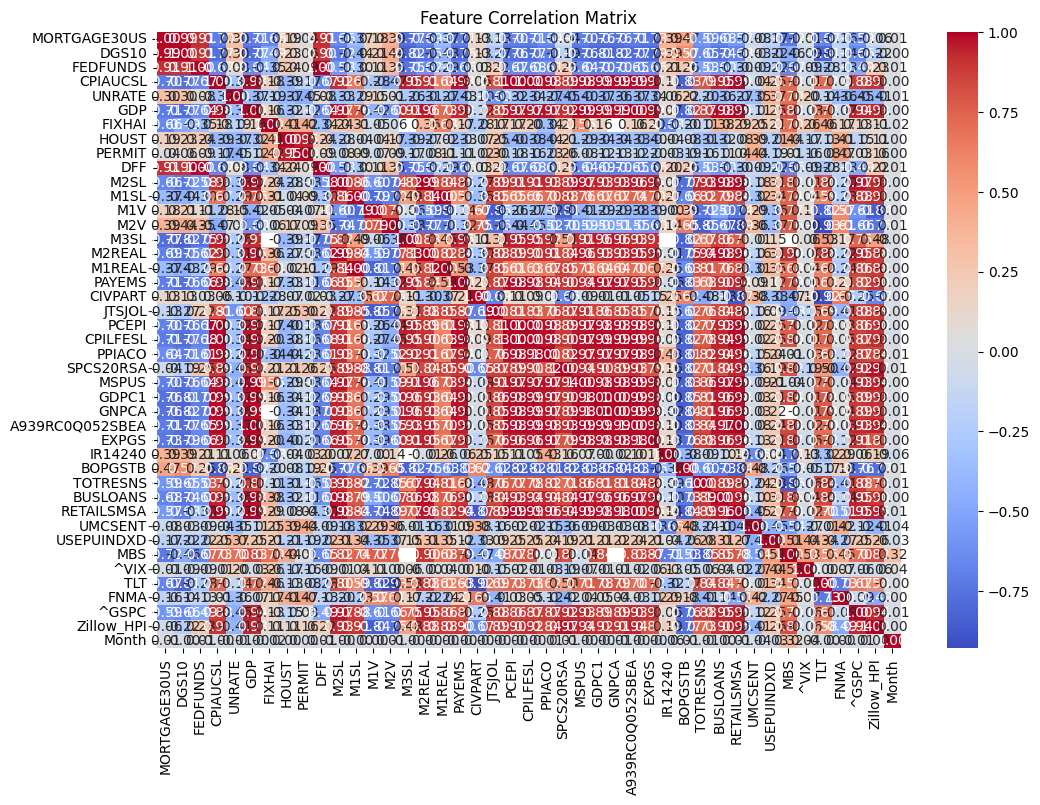

In [86]:
plt.figure(figsize=(12, 8))
sns.heatmap(combined.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Lag Feature Creation

In [87]:
for lag in [1, 2, 4, 8]:
    combined[f"MORTGAGE30US_{lag}"] = combined["MORTGAGE30US"].shift(lag)

# Save Data Locally

In [88]:
combined.to_csv("../data/full_mortgage_dataset.csv")